In [ ]:
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from keras.datasets import cifar10
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from numpy.matlib import repmat
import pandas as pd
from sklearn.preprocessing import normalize

In [ ]:
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()
data, labels = np.concatenate([train_data, test_data]), [i for j in np.concatenate([train_labels, test_labels]) for i in j]
plt.show()

In [ ]:
label_encoding = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

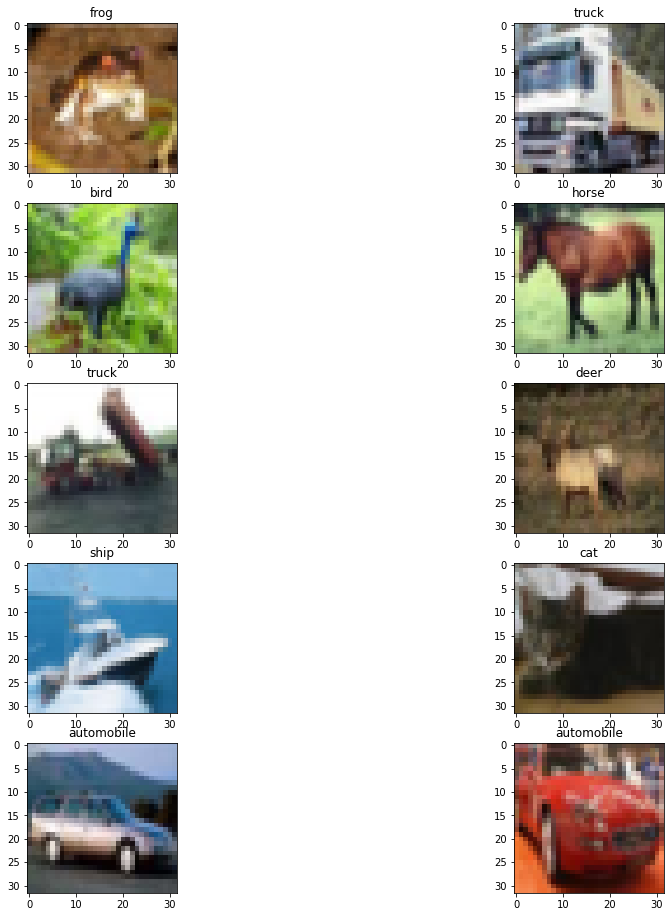

In [ ]:
## This plots first ten training pictures + labels, even index on left, odd index on right

f, axarr = plt.subplots(5,2,figsize=(16,16))
for i in range(0,10,2):
  axarr[i%5,0].set_title(label_encoding[labels[i]])
  axarr[i%5,0].imshow(train_data[i],interpolation='nearest')
  axarr[i%5,1].set_title(label_encoding[labels[i+1]])
  axarr[i%5,1].imshow(data[i+1],interpolation='nearest')

In [ ]:
reshaped_train=train_data.reshape(50000,3072)
reshaped_train.shape


(50000, 3072)

## PCA

In [ ]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [ ]:
x_train = train_data/255 #normalizing data
reshaped_train= x_train.reshape(50000,3072)
#find the mean of newfaces
newCifarMean = np.mean(reshaped_train, axis = 1)
#create a matrix for newFacesMean
newCifarMeanMatrix = repmat(newCifarMean,3072,1).T
#Find A by subtracting the newFacesMeanMatrix from newfaces
A = reshaped_train - newCifarMeanMatrix
#Find the eigenvalues and eigenvectors, and then sort
eigvals, eigvectors = np.linalg.eig(A.T @ A)
V, sortedEigvals = eigsort(eigvectors, eigvals)
newSortedEigvals = np.diagonal(sortedEigvals)
#Find and normalize U
u = A @ V
U = normc(u)

Text(0, 0.5, 'Eigenvalues')

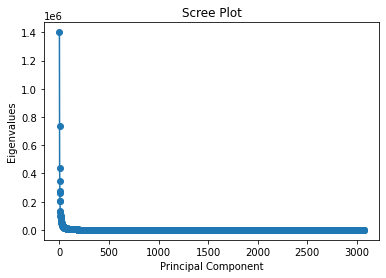

In [ ]:
eigenvalues = np.diagonal(sortedEigvals)
plt.plot(eigenvalues, '-o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')

In [ ]:
#A total of m or less components must be selected to comprise the chosen subspace. 
#Ideally, we would select k eigenvectors, called principal components, that have the k largest eigenvalues.
explained_variances = []
for i in range(len(newSortedEigvals)):
    explained_variances.append(newSortedEigvals[i] / np.sum(newSortedEigvals))
 
print(np.sum(explained_variances))
print(explained_variances)
#The first value is just the sum of explained variances — and must be equal to 1. 
#The second value is an array, representing the explained variance percentage per principal component.



0.9999999999999998
[0.19156850675154347, 0.10103129950028067, 0.059626944939720004, 0.04760606993800823, 0.03741964356985335, 0.03568812639742823, 0.028352963020744682, 0.027886233773771956, 0.01872929991743381, 0.01720943853281674, 0.01391896697657112, 0.013699790555700121, 0.013125475246104393, 0.011961346145485018, 0.011478663664171074, 0.010569318628583865, 0.009661227665567769, 0.009151022524345635, 0.008376827805536603, 0.00778092917528663, 0.0076719155011309315, 0.006457083605385983, 0.006395826036200793, 0.006314922256352581, 0.006069474110154428, 0.005897133233739044, 0.005781468398429357, 0.005226706934000013, 0.0051312157209058165, 0.00477802317441244, 0.004338572677922566, 0.0042221336786453885, 0.004040334698160255, 0.004006259641255085, 0.003793113315304816, 0.0034116774734435995, 0.0033768741444094672, 0.00331283998199395, 0.00323517421664777, 0.003160167446335531, 0.0029877302296023194, 0.0029716844150118756, 0.0028902138632906247, 0.002738105563872394, 0.00269350589595

In [ ]:
k=0
current=0
total=sum(explained_variances)
while current/total<0.96:
    current+=explained_variances[k]
    k+=1
k
#In the end, we see how PCA can be used to gain a deeper understanding of your data before modelling. 
#It will give you an idea of what sort of classification accuracy to expect.
#if we kept only the first 328 of the 3072 components we would retain 96% of the information contained in the original data however the accuracy of the model is the next step.

328

## K means

In [ ]:
#------------------------------
# This function calculates distance from every point in X to the mean of every cluster
# input: X(dataset with N observations with dimension D)
# input: Kmus(matrix of dimensions K x D)
# returns: sqDist(matric of N x K)
#------------------------------
def calcSqDistances(X, Kmus):
    #we will calculate distance from every point in X
    #to the mean of every cluster
    #for this, we need to store the distance from every point in x
    #to the mean of every cluster: Kmu
    
    #We need to find 
    # N = total number of rows in X
    # D = dimensionailty of every point in X
    # K = number of clusters
    
    K,D = Kmus.shape
    N, col = X.shape

    #size the array to return to NxK
    sqDist = np.zeros((N, K))
    #for each cluster, calculate the distance for every point in X
    # to the mean of the cluster
    for i in range (0,K):
        dist = np.linalg.norm(X-Kmus[i],axis=1)
        sqDist[:,i] = dist
        
    return sqDist

In [ ]:
#------------------------------
# This function determines the rnk(binary indicator variable of each data point)
# and indicates which cluster each data point belongs to
# input: sqDmat(matrix of distance of each data point to cluster mean, N x K)
# returns: rnk
#------------------------------
def determineRnk(sqDmat):
    N,K = sqDmat.shape
    rnk = np.zeros((N, K))
    
    #print(f'sqDmat is {sqDmat}')
    for i in range (0,N):
        indextoset = np.argmin(sqDmat[i])
        rnk[i][indextoset] = 1
    return rnk

In [ ]:
#------------------------------
# This function recalculates the mus
# input: x(dataset with N observations with dimension D)
# input: Rnk(binary indicator variable of each data point)
# returns: newKmus(matrix of K x D)
#------------------------------
def recalcMus(X, Rnk):
    # find all the values of x for each cluster, then
    # to do this, take the transpose of rnk and make it rkn, and 
    # row k indicates the cluster which a n value belongs to
    rows,K = Rnk.shape
    N,D = X.shape
    Rkn = Rnk.T
    
    newKmus = np.zeros((K, D))
    
    #print(f'Rkn is {Rkn.shape}')
    for i in range(0,K):
        #print (f'i = {i} k = {K}')
        clusterArray = X[Rkn[i]==1]
        clusterMean = np.mean(clusterArray, axis=0)
        newKmus[i] = clusterMean
    
    return newKmus   

In [ ]:
#------------------------------
# This function runs K means using the calcSqDistances, determineRnk, and 
# recalcMus functions
# input: K(number of clusters)
# returns: Kmus(matrix of dimensions K x D)
#------------------------------
def runKMeans(K, X):
    X = reshaped_train
    #determine and store data set information
    N, D = reshaped_train.shape
    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))
    #initialize cluster centers by randomly picking points from the data
    rand = np.random.permutation(N)
    Kmus = X[rand[:K]];

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        #plotCurrent(X, Rnk, Kmus)
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break

        return Kmus

    #plotCurrent(X, Rnk, Kmus)

In [ ]:
kmeans = runKMeans(10,reshaped_train)

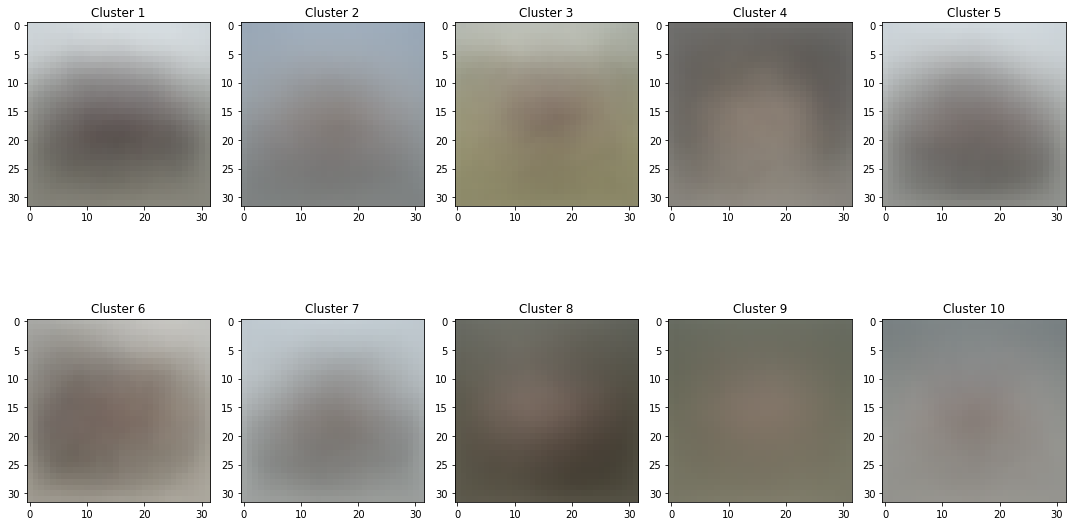

In [ ]:
def get_cluster_plot(Kmus, rows = 2): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = np.array(Kmus[i].reshape(32,32, 3))
        cluster = cluster.astype(int)
        axs[i//5][i%5].imshow(cluster)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')
    plt.tight_layout()

get_cluster_plot(kmeans)

##GMM 

In [ ]:
def gaussian(x, mu, cov):
        #print(f"x = {x.shape}, mu = {mu.shape}, cov = {cov.shape}")
        #print("hello2")
        d = np.shape(x)[1]
        mu = mu[None, :]
        #print(f"mu={mu}")
        dr = 1/(np.sqrt((2* np.pi)**(d) * np.linalg.det(cov)))
        nr = (np.exp(-np.diag((x - mu)@(np.linalg.inv(cov))@((x - mu).T) / 2)))
        #print(f"nr.shape={nr.shape}")
        #print(f"dr.shape={dr.shape}")
        return nr * dr

In [ ]:
#Bishop Equation 9.13
def calcRespons(X,K, pi, mu, covariance):
        numerator = np.zeros((X.shape[0],K))
        for i in range (K):
            numerator[:,i] = pi[i]*gaussian(X, mu[i], np.diag(covariance[i]))
        denominator = np.sum(numerator, axis=1, keepdims = True)
        return np.divide(numerator, denominator)

In [ ]:
def recalcParam(X, K, gamma):
    N, D = X.shape

    #Re-estimate means(9.17), covariances(9.19), and mixing coefficients(9.22)

    #9.22
    pi = np.sum(gamma, axis=0)/N

    #9.17
    mu_k = np.zeros((K,D))
    for i in range (K):
        #mu_k[i] = np.divide((gamma[:,i].T @ ((X-mu_k[i])**2))[i], np.sum(gamma[:,i]))
        mu_k[i] = np.divide((gamma[:,i].T @ ((X-mu_k[i])**D))[i], np.sum(gamma[:,i]))


    #9.19
    variance = np.zeros((K,D))
    for i in range (K):
        #variance[i] = np.divide((gamma[:,i].T @ ((X-mu_k[i])**2)), np.sum(gamma[:,i]))
        variance[i] = np.divide((gamma[:,i].T @ ((X-mu_k[i])**D)), np.sum(gamma[:,i]))
        variance[variance < 0.01]=0.01

    return pi, mu_k, variance

In [ ]:
def runGMM(reshaped_train, K, pi_old, mu_old, variance_old):
    X = reshaped_train
    N, D = X.shape
    gamma = np.zeros((N,K))
    for iter in range (1000):
        #E-step
        gamma = calcRespons(X, K, pi_old, mu_old, variance_old)
        #M-step
        pi_new, mu_new, variance_new = recalcParam(X, K, gamma)
        
        if np.sum(np.abs(mu_old.reshape((-1,1)) - mu_new.reshape((-1,1)))) < 1e-3:
            print(f"Success in iteration={iter}")
            print(gamma)
            #plotCurrent(X, gamma, Kmus)
            break
        
        
        pi_old, mu_old, variance_old = pi_new, mu_new, variance_new
    
    return pi_old, mu_old, variance_old

In [ ]:
reshaped_train.shape

(50000, 3072)

In [ ]:
mu_old = runKMeans(10,reshaped_train)
#office hours explains pi and var initialization
pi_old = np.asarray([1/2]*10)
#making symmetric and positive definite matrix to meet requirements
variance_old = np.zeros((10,10))

for i in range(len(variance_old)):
    variance_old[i] = np.asarray([10,10,10,10,10,10,10,10,10,10])
variance_old

K = 10



In [ ]:
runGMM(reshaped_train, 10, pi_old, mu_old, variance_old)

OverflowError: ignored

In [ ]:
D = 2
K = 10
pi = np.asarray([1/K]*K)
mu = runKMeans(10,reshaped_train)
variance = np.zeros((K,D))
for i in range(len(variance)):
    variance[i] = np.asarray([2,3])

pi_new, mu_new, variance_new = runGMM(reshaped_train, K, pi, mu, variance)
print(f"mu={mu}")
print(f"mu_new={mu_new}")

print(f"variance_new={variance_new}")
print(f"pi_new={pi_new}")




OverflowError: ignored

In [ ]:
runGMM(reshaped_train, K, pi_old, mu_old, variance_old)

OverflowError: ignored

In [ ]:
oldvar = np.zeros((34,34))
oldPi = np.asarray([1/2]*10)

for i in range (len(oldvar)):
    oldvar[i] = np.asarray([2,3])
newMu, newVar, newPi, gamma = runGMM(reshaped_train, 10, oldPi, oldMu, oldvar)
get_cluster_plot(newMu)

ValueError: ignored